# Seasonal temperature variation at and close to the surface

To optimize the installation and performance of shallow heat exchangers, knowledge of seasonal temperature signals close the surface is desired. The systematic seasonal fluctuation of solar radiation and air temperature imparts a temperature wave to the ground surface that propagates downward into the earth. The temperature at depth oscillates with the same (annual) frequency as the surface temperature, but with an amplitude that
diminishes and a phase lag that increases with depth. Eventually, a point is reached where the temperature remains essentially constant, except for any long-term drift related to climatic changes, for example. This
depth of 'zero' annual amplitude may be 10 to 15 metres in soils, but can be much deeper in rock. 

Before we look at the temperature evolution at depth, we have a look at the mean average air temperatures in Aachen last year (2018). The German weather service "Deutscher Wetterdienst" (DWD) provides climate data of more than 70 observational stations in Germany from the monitoring network with free access. The data has been obtained [here](https://icdc.cen.uni-hamburg.de/1/daten/atmosphere/dwd-station.html) and is given in the CSV file `Temp_Aachen_2018.csv`.

## Task 1): Surface temperatures

Load and visualize the temperature data and approximate its seasonal variation by a cosine function of the following form:

$$T(z=0, t)=T_{mean}+T_{D} \cos (\omega t+\varphi)$$

Here $T_{mean}$ is the average air temperature, $T_{D}$ is the amplitude, $\omega=2\pi/P$ is the angular frequency, where P is the period of the temperature signal (one year), and $\varphi$ is the phase lag.

Estimate the root-mean-square error (RMSE) between observations and their sinusoidal approximation.

### Solution:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
temp = np.loadtxt("data/Temp_Aachen_2018.csv", delimiter=",")[:,1]

In [3]:
# Define some helper variables
n = 1000
days = 365
z = np.linspace(0,20, n)
year = np.arange(days)

# Define parameters of function
Tm = np.mean(temp)
Td = 9
omega = 2*np.pi/days
phi = np.pi * 0.85

T_s = Tm + Td * np.cos(omega*year + phi)

# Calculate fit
RMSE = np.sqrt(((T_s - temp)**2).mean())

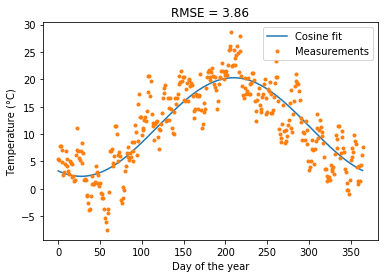

In [4]:
# Visualize result
plt.plot(year, T_s, label="Cosine fit")
plt.plot(year, temp,'.', label="Measurements")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("RMSE = %.2f" % RMSE)
plt.legend()

## Task 2): Ground temperatures

The temperature at depth $z$ for the temperature variation at the surface $T(z=0, t)$ (calculated in Task 1) is defined as (Carslaw & Jaeger, 1959):

$$T(z, t)= T_{\text {mean}}+ d T / d z \cdot z +T_{D} \exp (-\sqrt{\omega /(2 \kappa)} z) \cos (\omega t-\sqrt{\omega /(2 \kappa)} z+\varphi)$$

Here $d T / d z$ is the average temperature gradient and $\kappa$ is the thermal diffusivity.

Calculate and visualize the temperature profile for the first 20 m of the subsurface using a thermal diffusivity of $0.5 \times 10^{-5}$m$^2$/s for every third month of the year.

### Solution:

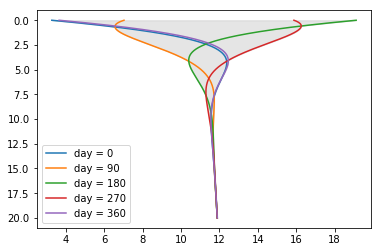

In [5]:
kappa = 0.5e-6 * 60 * 60 * 24
mt = []
fig, ax = plt.subplots()

for t in year[::90]:
    T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(omega*t - np.sqrt(omega/(2*kappa)) * z + phi)
    mt.append(T)
    ax.plot(T, z, label="day = %d" % t)
    
ax.invert_yaxis()
mt = np.array(mt)
ax.legend()
ax.fill_betweenx(z, np.min(mt, axis=0), np.max(mt, axis=0), alpha=0.1, color="k")

### References
- Carslaw, H. S., and J. C. Jaeger, 1959: Conduction of Heat in Solids.
2nd ed. Oxford University Press, 510 pp.

---
## Bonus questions: 
### 1) Try to find better parameters for Task 1 (seasonal air temperature fit) using [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

To make the problem suitable for optimization, we need a function with parameters and a return value that should be minimized.

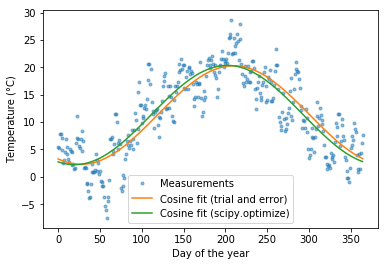

In [6]:
def func(params):
    Tm, Td, phi = params
    omega = 2*np.pi/days
    T_s = Tm + Td * np.cos(omega*year + phi)
    RMSE = np.sqrt(((T_s - temp)**2).mean())
    return RMSE

from scipy.optimize import minimize
params = Tm, Td, phi # initial guess
result = minimize(func, params)

Tm_opt, Td_opt, phi_opt = result.x
T_s_opt = Tm_opt + Td_opt * np.cos(omega*year + phi_opt)

plt.plot(year, temp,'.', label="Measurements", alpha=0.5)
plt.plot(year, T_s, label="Cosine fit (trial and error)")
plt.plot(year, T_s_opt, label="Cosine fit (scipy.optimize)")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.legend()

### 2) Make an animation of the yearly ground temperature evolution using matplotlib. A simple example is given below:

In [7]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))

def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
HTML(ani.to_html5_video())
plt.clf()

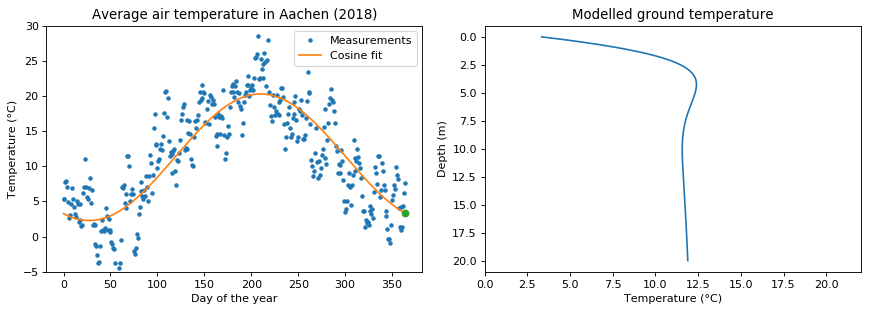

In [8]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4), dpi=80)
ax1.set_title("Average air temperature in Aachen (2018)")
ax2.set_title("Modelled ground temperature")
ax1.set_xlabel("Day of the year")
ax1.set_ylabel("Temperature (°C)")
ax2.set_xlabel("Temperature (°C)")
ax2.set_ylabel("Depth (m)")
ax2.set_xlim(0,22)
ax1.plot(year, temp,'.', label="Measurements")
ax1.plot(year,T_s, label="Cosine fit")
vline, = ax1.plot(0, T[0], "o", color="tab:green", ms=6)
ax1.set_ylim(-5,30)
ax1.legend()

T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(- np.sqrt(omega/(2*kappa)) * z + phi)
line, = ax2.plot(T, z)
ax2.invert_yaxis()

# initialization function: plot the background of each frame
def init():
    line.set_data(T, z)
    vline.set_data(0,T[0])
    return line, vline,

# animation function. This is called sequentially
def animate(i):
    t = i
    T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(omega*t - np.sqrt(omega/(2*kappa)) * z + phi)
    line.set_data(T, z)
    vline.set_data(i, T[0])
    return line, vline,

fig.tight_layout()

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=365, interval=20, blit=True)
HTML(anim.to_html5_video())
#anim.save("animation.gif", writer="imagemagick")